## 基于python基础库，搭建卷积神经网络，并用该网络进行手写字符识别

#### 本程序主要基于python的numpy、math等基础函数库，完成了CNN训练的前向传播、后向传播、随机梯度下降更新等主要的函数功能；

#### 并基于该程序，在MNIST数据集上进行手写字符识别。

In [1]:
from __future__ import absolute_import,division,print_function

import gzip
import os
import time
import sys
import math
from six.moves import xrange
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#包推荐版本见requirements

### 一些超参数设置

In [2]:
IMAGE_SIZE=28           #图片大小
NUM_CHANNELS=1          #输入图片通道数
PIXEL_DEPTH=255         #灰度
BATCH_SIZE=64           #训练时的batch size
NUM_LABELS=10           #类别数量
MAX_EPOCHS = 1          #训练epochs
SEED=2330               #random seed
EVAL_FREQUENCY = 100    #验证频率
EVAL_BATCH_SIZE = 64    #验证时的batch size

### 载入MNIST训练数据集，并将训练集划分出验证集

具体函数请参看`data_helper.py`文件，已实现

In [3]:
from data_helper import load_train,load_test

def onehot(targets, num):
    result = np.zeros((num, 10))
    for i in range(num):
        result[i][targets[i]] = 1
    return result

validation_size = 5000
train_data,train_labels,validation_data,validation_labels = load_train(validation_size, IMAGE_SIZE, NUM_CHANNELS, PIXEL_DEPTH)
test_data,test_labels = load_test(IMAGE_SIZE, NUM_CHANNELS, PIXEL_DEPTH)

train_labels = onehot(train_labels, 55000)
validation_labels = onehot(validation_labels, validation_size)
train_size = train_labels.shape[0]
print("train data size: ",len(train_data))
print("train data shape: ",train_data.shape)
print("train label shape: ",train_labels.shape)
print("test data shape: ", test_data.shape)
print("test label shape: ", test_labels.shape)

Extracting data,  ./data/train-images-idx3-ubyte.gz
Extracting labels, ./data/train-labels-idx1-ubyte.gz
Extracting data,  ./data/t10k-images-idx3-ubyte.gz
Extracting labels, ./data/t10k-labels-idx1-ubyte.gz
train data size:  55000
train data shape:  (55000, 28, 28, 1)
train label shape:  (55000, 10)
test data shape:  (10000, 28, 28, 1)
test label shape:  (10000,)


图片示例：

y is: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


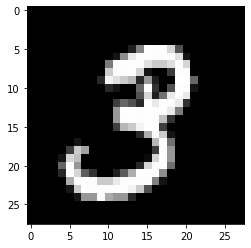

In [4]:
index = 1
plt.imshow(train_data[index].reshape((28,28)),cmap = plt.cm.gray)
print("y is: "+str(train_labels[index]))

### 1. 卷积操作

In [5]:
class Convolution:
    def __init__(self, layer_shape, k_size=5, k_num=32, strides=1, seed=2330):
        # 随机数种子
        self.seed = seed
        np.random.seed(self.seed)

        # 输入的维度 （batch，height，width，channels）
        self.input_shape = layer_shape
        self.input_batch = layer_shape[0]
        self.input_height = layer_shape[1]
        self.input_width = layer_shape[2]
        self.input_channels = layer_shape[3]
        
        # 卷积核的维度
        self.k_size = k_size
        self.strides = strides
        if (self.input_height-self.k_size) % self.strides != 0:
            print("input tensor height can\'t fit strides!")
        if (self.input_width-self.k_size) % self.strides != 0:
            print("input tensor width can\'t fit strides!")

        # 输出的维度
        self.output_batch = self.input_batch
        self.output_height = (self.input_height-self.k_size) // self.strides + 1
        self.output_width = (self.input_width-self.k_size) // self.strides + 1
        self.output_channels = k_num
        self.delta = np.zeros((self.output_batch, self.output_height, self.output_width, self.output_channels))
        self.output_shape = self.delta.shape
        
        # 卷积权重及梯度初始化
        weights_scale = math.sqrt(k_size*k_size*self.output_channels/2)
        self.weights = np.random.standard_normal((k_size, k_size, self.input_channels, self.output_channels)) / weights_scale
        self.bias = np.random.standard_normal(self.output_channels) / weights_scale
        self.w_gradient = np.zeros(self.weights.shape)
        self.b_gradient = np.zeros(self.bias.shape)
    
    # 卷积优化方法，参考《High Performance Convolutional Neural Networks for Document Processing》
    def img2col(self, image, ksize, stride):
        # image([batchsize, width ,height, channel])
        # 取出所有要和kernel做卷积的图像区域
        image_col = []
        for i in range(0, image.shape[1] - ksize + 1, stride):
            for j in range(0, image.shape[2] - ksize + 1, stride):
                col = image[:, i:i + ksize, j:j + ksize, :].reshape([-1])
                image_col.append(col)
        image_col = np.array(image_col)

        return image_col
        
    # 计算卷积的前向传播和部分反向求导的参数更新（20 points）
    def forward(self, X):
        ### start your code
        # tips: 对一个batch，逐图片找其要计算的所有区域，计算卷积
        self.col_image = []
        col_weights = self.weights.reshape([-1, self.output_channels])
        conv_out = np.zeros(self.delta.shape)
        for i in range(self.input_batch):
            self.col_image.append(self.img2col(X[i][np.newaxis,:], self.k_size, self.strides))
            conv = np.dot(self.col_image[i], col_weights) + self.bias
            conv_out[i] = np.reshape(conv, self.delta[0].shape)
        self.col_image = np.array(self.col_image)
        ###end your code
        return conv_out
        
    # backward函数：1.更新本层参数，2.将梯度继续向后传播
    # 传入的参数delta为Loss对本层output元素的导数
    # self.delta（即返回值）为Loss对本层input元素（即上一层的output）的导数
    def backward(self, delta, lr=0.0001, weight_decay=0.0004):
        self.delta = delta
        col_delta = np.reshape(delta, [self.input_batch, -1, self.output_channels])
        
        for i in range(self.input_batch):
            self.w_gradient += np.dot(self.col_image[i].T, col_delta[i]).reshape(self.weights.shape)
        self.b_gradient += np.sum(col_delta, axis=(0,1)) 

        pad_delta = np.pad(self.delta, 
                            ((0, 0), (self.k_size - 1, self.k_size - 1), (self.k_size - 1, self.k_size - 1), (0, 0)),
                            'constant', constant_values=0)

        flip_weights = np.flipud(np.fliplr(self.weights))
        flip_weights = flip_weights.swapaxes(2, 3)
        col_flip_weights = flip_weights.reshape([-1, self.input_channels])
        col_pad_delta = np.array([self.img2col(pad_delta[i][np.newaxis, :], self.k_size, self.strides) for i in range(self.input_batch)])
        delta_back = np.dot(col_pad_delta, col_flip_weights)
        delta_back = np.reshape(delta_back, self.input_shape)
        
        #参数更新
        # update weights，bias，清空w_gradient, b_gradient
        ### start your code
        # tips: weight decay使用：(1-weight_decay)*(weight或者bias)-lr*(w_gradient或者b_gradient),作为一个权重使用
        self.weights = (1-weight_decay)*self.weights - lr*self.w_gradient
        self.bias = (1-weight_decay)*self.bias - lr*self.b_gradient
        self.w_gradient = np.zeros(self.weights.shape)
        self.b_gradient = np.zeros(self.bias.shape)
        ###end your code
        return delta_back

def test_():
    index = 1
    img = train_data[index:index+2, ...]
    y = train_labels[index:index+2,...]
    print("img.shape: \t", img.shape)
    
    conv = Convolution(img.shape, k_size=3, k_num=2, strides=1, seed=2330)
    conv_out = conv.forward(img)
    print("conv_out.shape: ", conv_out.shape)

    
    conv_back = conv.backward(conv_out, lr=0.0001)
    print("conv_back.shape:", conv_back.shape)
    
test_()

img.shape: 	 (2, 28, 28, 1)
conv_out.shape:  (2, 26, 26, 2)
conv_back.shape: (2, 28, 28, 1)


expect outputs:
    
    img.shape:       (2, 28, 28, 1)
    conv_out.shape:  (2, 26, 26, 2)
    conv_back.shape: (2, 28, 28, 1)

### 2. ReLu 层

In [6]:
# rule Activator
class Relu:  
    def __init__(self, input_shape):
        self.delta = np.zeros(input_shape)
        self.input_shape = input_shape
        self.output_shape = self.input_shape
    
    #根据relu函数的形式，写出其前向传播与反向求导的值 （10 points）
    def forward(self, x):
        self.x = x
        ###start your code
        result = np.maximum(0, x)
        ###end your code
        return result
    
    def backward(self, delta):
        ###start your code
        delta[self.x < 0] = 0
        self.delta = delta
        ###end your code 
        return delta
    
def test_():
    index = 1
    img = train_data[index:index+2, ...]
    y = train_labels[index:index+2,...]
    print("img.shape: \t", img.shape)
    
    conv = Convolution(img.shape, k_size=3, k_num=2, strides=1, seed=2330)
    conv_out = conv.forward(img)
    print("conv_out.shape: ", conv_out.shape)

    relu=Relu(conv_out.shape)
    relu_out = relu.forward(conv_out)
    print("relu_out.shape: ", relu_out.shape)
    
    relu_back = relu.backward(relu_out)
    print("relu_back.shape:", relu_back.shape)
    
    conv_back = conv.backward(relu_back, lr=0.0001)
    print("conv_back.shape:", conv_back.shape)
    
test_()

img.shape: 	 (2, 28, 28, 1)
conv_out.shape:  (2, 26, 26, 2)
relu_out.shape:  (2, 26, 26, 2)
relu_back.shape: (2, 26, 26, 2)
conv_back.shape: (2, 28, 28, 1)


expect output:
    
    img.shape: 	  (2, 28, 28, 1)
    conv_out.shape:  (2, 26, 26, 2)
    relu_out.shape:  (2, 26, 26, 2)
    relu_back.shape: (2, 26, 26, 2)
    conv_back.shape: (2, 28, 28, 1)

### 3. max_pooling 层

In [7]:
class max_pool:
    def __init__(self, input_shape, k_size=2, strides=2):
        self.input_shape = input_shape
        self.k_size = k_size
        self.strides = strides
        self.output_shape = [input_shape[0], input_shape[1]//self.strides, input_shape[2]//self.strides, input_shape[3]]
        self.feature_mask = np.zeros(input_shape)
    
    #计算最大池化的前向传播和反向求导(20 points)
    def forward(self, x):
        ### start your code
        # tips：记录最大池化时最大值的位置信息设为类的变量self.feature_mask，用于反向传播
        #       活用np.argmax, 切片等操作
        feature = np.zeros(self.output_shape)
        for batch in range(self.input_shape[0]):
            for channel in range(self.input_shape[3]):
                for i in range(0, self.input_shape[1], self.strides):
                    for j in range(0, self.input_shape[2], self.strides):
                        pool = x[batch, i:i+self.k_size, j:j+self.k_size, channel]
                        max_index = np.argmax(pool)
                        feature[batch, i//self.strides, j//self.strides, channel] = pool.flatten()[max_index]   # 最大值
                        self.feature_mask[batch, i + max_index//self.k_size, j + max_index%self.k_size, channel] = 1    # 取得最大值的位置
        ### end your code
        return feature

    def backward(self, delta):
        # ### start your code
        # delta_back = np.zeros(self.input_shape)
        # for i in range(delta.shape[1]):
        #     for j in range(delta.shape[2]):
        #         delta_back[:, i*self.strides:(i+1)*self.strides, j*self.strides:(j+1)*self.strides, :] = delta[:, i, j, :] * self.feature_mask[:, i*self.strides:(i+1)*self.strides, j*self.strides:(j+1)*self.strides, :]
        # ### end your code
        # return delta_back
        return np.repeat(np.repeat(delta, self.strides, axis=1), self.strides, axis=2) * self.feature_mask  # ???
    
def test_():
    index = 1
    img = train_data[index:index+2, ...]
    y = train_labels[index:index+2,...]
    print("img.shape: \t", img.shape)
    
    conv = Convolution(img.shape, k_size=3, k_num=2, strides=1, seed=2330)
    conv_out = conv.forward(img)
    print("conv_out.shape: ", conv_out.shape)

    relu=Relu(conv_out.shape)
    relu_out = relu.forward(conv_out)
    print("relu_out.shape: ", relu_out.shape)
    
    pool = max_pool(relu_out.shape,2,2)
    pool_out = pool.forward(relu_out)
    print("pool_out.shape: ", pool_out.shape)
    
    pool_back = pool.backward(pool_out)
    print("pool_back.shape:", pool_back.shape)
    
    relu_back = relu.backward(pool_back)
    print("relu_back.shape:", relu_back.shape)
    
    conv_back = conv.backward(relu_back, lr=0.0001)
    print("conv_back.shape:", conv_back.shape)
    
test_()
    

img.shape: 	 (2, 28, 28, 1)
conv_out.shape:  (2, 26, 26, 2)
relu_out.shape:  (2, 26, 26, 2)
pool_out.shape:  (2, 13, 13, 2)
pool_back.shape: (2, 26, 26, 2)
relu_back.shape: (2, 26, 26, 2)
conv_back.shape: (2, 28, 28, 1)


expect output:
    
    img.shape: 	  (2, 28, 28, 1)
    conv_out.shape:  (2, 26, 26, 2)
    relu_out.shape:  (2, 26, 26, 2)
    pool_out.shape:  (2, 13, 13, 2)
    pool_back.shape: (2, 26, 26, 2)
    relu_back.shape: (2, 26, 26, 2)
    conv_back.shape: (2, 28, 28, 1)

In [8]:
class flatten:
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.output_shape = [self.input_shape[0], self.input_shape[1] * self.input_shape[2] * self.input_shape[3]]
        
    def forward(self, x):
        y = x.reshape([self.input_shape[0], self.input_shape[1] * self.input_shape[2] * self.input_shape[3]])
        return y
    
    def backward(self, y):
        x = np.reshape(y, [self.input_shape[0], self.input_shape[1], self.input_shape[2], self.input_shape[3]])
        return x

def test_():
    index = 1
    img = train_data[index:index+2, ...]
    y = train_labels[index:index+2,...]
    print("img.shape: \t", img.shape)
    
    conv = Convolution(img.shape, k_size=3, k_num=2, strides=1, seed=2330)
    conv_out = conv.forward(img)
    print("conv_out.shape: ", conv_out.shape)

    relu=Relu(conv.output_shape)
    relu_out = relu.forward(conv_out)
    print("relu_out.shape: ", relu_out.shape)
    
    pool = max_pool(relu.output_shape,2,2)
    pool_out = pool.forward(relu_out)
    print("pool_out.shape: ", pool_out.shape)
    
    flat = flatten(pool.output_shape)
    flat_out = flat.forward(pool_out)
    print("flat_out.shape: ", flat_out.shape)
    
    flat_back = flat.backward(flat_out)
    print("flat_back.shape:", flat_back.shape)
    
    pool_back = pool.backward(flat_back)
    print("pool_back.shape:", pool_back.shape)
    
    relu_back = relu.backward(pool_back)
    print("relu_back.shape:", relu_back.shape)
    
    conv_back = conv.backward(relu_back, lr=0.0001)
    print("conv_back.shape:", conv_back.shape)
    
test_()

img.shape: 	 (2, 28, 28, 1)
conv_out.shape:  (2, 26, 26, 2)
relu_out.shape:  (2, 26, 26, 2)
pool_out.shape:  (2, 13, 13, 2)
flat_out.shape:  (2, 338)
flat_back.shape: (2, 13, 13, 2)
pool_back.shape: (2, 26, 26, 2)
relu_back.shape: (2, 26, 26, 2)
conv_back.shape: (2, 28, 28, 1)


### 4. 全连接层


In [9]:
class full_connection:
    def __init__(self, input_shape, output_channels, seed=2330):
        self.input_shape = input_shape
        self.input_batch = input_shape[0]
        self.input_length = input_shape[1]
        self.output_channels = output_channels
        
        self.seed = seed
        np.random.seed(self.seed)
        
        weights_scale = math.sqrt(self.input_length/2) 
        self.weights = np.random.standard_normal((self.input_length,self.output_channels)) / weights_scale
        self.bias = np.random.standard_normal(self.output_channels) / weights_scale
        
        self.output_shape = [self.input_batch, self.output_channels]
        self.w_gradient = np.zeros(self.weights.shape)
        self.b_gradient = np.zeros(self.bias.shape)
    
    #计算全连接的前向传播，反向求导 (20 points)
    def forward(self, x):
        ### start your code
        # tips: wx+b形式
        self.x = x
        y = np.dot(self.x, self.weights) + self.bias
        ### end your code
        return y
    
    def backward(self, delta, lr=0.0001, weight_decay=0.0004):
        ### start your code
        # tips: weight decay使用：(1-weightdecay)*weight-lr*w_gradient, bias类似
        self.w_gradient = np.dot(self.x.T, delta)
        self.b_gradient = np.sum(delta, axis=0)
        delta_back = np.dot(delta, self.weights.T)
        
        self.weights = (1 - weight_decay) * self.weights - lr * self.w_gradient
        self.bias = (1 - weight_decay) * self.bias - lr * self.b_gradient
        ### end your code
        return delta_back
    
def test_():
    index = 1
    img = train_data[index:index+2, ...]
    y = train_labels[index:index+2,...]
    print("img.shape: \t", img.shape)
    
    conv = Convolution(img.shape, k_size=3, k_num=2, strides=1, seed=2330)
    conv_out = conv.forward(img)
    print("conv_out.shape: ", conv_out.shape)

    relu=Relu(conv.output_shape)
    relu_out = relu.forward(conv_out)
    print("relu_out.shape: ", relu_out.shape)
    
    pool = max_pool(relu.output_shape,2,2)
    pool_out = pool.forward(relu_out)
    print("pool_out.shape: ", pool_out.shape)
    
    flat = flatten(pool.output_shape)
    flat_out = flat.forward(pool_out)
    print("flat_out.shape: ", flat_out.shape)
    
    fc = full_connection(flat.output_shape,10,seed=SEED)
    fc_out = fc.forward(flat_out)
    print("fc_out.shape: \t", fc_out.shape)
    
    fc_back = fc.backward(fc_out,lr=0.0001)
    print("fc_back.shape: \t",fc_back.shape)
    
    flat_back = flat.backward(fc_back)
    print("flat_back.shape:", flat_back.shape)
    
    pool_back = pool.backward(flat_back)
    print("pool_back.shape:", pool_back.shape)
    
    relu_back = relu.backward(pool_back)
    print("relu_back.shape:", relu_back.shape)
    
    conv_back = conv.backward(relu_back, lr=0.0001)
    print("conv_back.shape:", conv_back.shape)
    
test_()

img.shape: 	 (2, 28, 28, 1)
conv_out.shape:  (2, 26, 26, 2)
relu_out.shape:  (2, 26, 26, 2)
pool_out.shape:  (2, 13, 13, 2)
flat_out.shape:  (2, 338)
fc_out.shape: 	 (2, 10)
fc_back.shape: 	 (2, 338)
flat_back.shape: (2, 13, 13, 2)
pool_back.shape: (2, 26, 26, 2)
relu_back.shape: (2, 26, 26, 2)
conv_back.shape: (2, 28, 28, 1)


expect output:

    img.shape: 	  (2, 28, 28, 1)
    conv_out.shape:  (2, 28, 28, 2)
    relu_out.shape:  (2, 28, 28, 2)
    pool_out.shape:  (2, 14, 14, 2)
    flat_out.shape:  (2, 392)
    fc_out.shape:    (2, 10)
    fc_back.shape:   (2, 392)
    flat_back.shape: (2, 14, 14, 2)
    pool_back.shape: (2, 28, 28, 2)
    relu_back.shape: (2, 28, 28, 2)
    conv_back.shape: (2, 28, 28, 1)

### 5. Softmax 层

In [10]:
class Softmax:
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.input_batch = input_shape[0]
        self.class_num = input_shape[1]
        
        self.softmax = np.zeros(self.input_shape)
        self.delta = np.zeros(self.input_shape)
        
    def cal_loss(self, x, label):
        self.prediction(x)
        loss = 0
        for i in range(self.input_batch):
            loss -= np.sum(np.log(self.softmax[i]) * label[i])
        loss /= self.input_batch
        return loss
    
    #计算softmax的前向传播，反向求导（10 points）
    def prediction(self, x):
        for i in range(self.input_batch):
            ### start your code
            self.softmax[i] = np.exp(x[i]) / np.sum(np.exp(x[i]))
            ## end your code
        return self.softmax
    
    def backward(self, label):
        self.delta = self.softmax.copy()
        ### start your code
        self.delta -= label
        ## end your code
        return self.delta / self.input_batch
    
def test_():
    index = 1
    img = train_data[index:index+2, ...]
    y = train_labels[index:index+2,...]
    print("img.shape: \t", img.shape)
    
    conv = Convolution(img.shape, k_size=5, k_num=32, strides=1, seed=2330)
    conv_out = conv.forward(img)
    print("conv_out.shape: ", conv_out.shape)

    relu=Relu(conv.output_shape)
    relu_out = relu.forward(conv_out)
    print("relu_out.shape: ", relu_out.shape)
    
    pool = max_pool(relu.output_shape,2,2)
    pool_out = pool.forward(relu_out)
    print("pool_out.shape: ", pool_out.shape)
    
    flat = flatten(pool.output_shape)
    flat_out = flat.forward(pool_out)
    print("flat_out.shape: ", flat_out.shape)
    
    fc = full_connection(flat.output_shape,10,seed=SEED)
    fc_out = fc.forward(flat_out)
    print("fc_out.shape: \t", fc_out.shape)
    
    softmax = Softmax(fc.output_shape)
    
    pred = softmax.prediction(fc_out)
    print("pred.shape: \t", pred.shape)
    
    loss = softmax.cal_loss(fc_out, y)
    print("loss:  \t\t", loss)
    
    loss_back = softmax.backward(label=y)
    print("loss_back.shape:", loss_back.shape)
    
    fc_back = fc.backward(loss_back,lr=0.0001)
    print("fc_back.shape: \t",fc_back.shape)
    
    flat_back = flat.backward(fc_back)
    print("flat_back.shape:", flat_back.shape)
    
    pool_back = pool.backward(flat_back)
    print("pool_back.shape:", pool_back.shape)
    
    relu_back = relu.backward(pool_back)
    print("relu_back.shape:", relu_back.shape)
    
    conv_back = conv.backward(relu_back, lr=0.0001)
    print("conv_back.shape:", conv_back.shape)
    
    
test_()

img.shape: 	 (2, 28, 28, 1)
conv_out.shape:  (2, 24, 24, 32)
relu_out.shape:  (2, 24, 24, 32)
pool_out.shape:  (2, 12, 12, 32)
flat_out.shape:  (2, 4608)
fc_out.shape: 	 (2, 10)
pred.shape: 	 (2, 10)
loss:  		 2.21567614580648
loss_back.shape: (2, 10)
fc_back.shape: 	 (2, 4608)
flat_back.shape: (2, 12, 12, 32)
pool_back.shape: (2, 24, 24, 32)
relu_back.shape: (2, 24, 24, 32)
conv_back.shape: (2, 28, 28, 1)


expect output:
    
    img.shape: 	  (2, 28, 28, 1)
    conv_out.shape:  (2, 24, 24, 32)
    relu_out.shape:  (2, 24, 24, 32)
    pool_out.shape:  (2, 12, 12, 32)
    flat_out.shape:  (2, 4608)
    fc_out.shape:    (2, 10)
    pred.shape: 	 (2, 10)
    loss:  		   2.32...
    loss_back.shape: (2, 10)
    fc_back.shape:   (2, 4608)
    flat_back.shape: (2, 12, 12, 32)
    pool_back.shape: (2, 24, 24, 32)
    relu_back.shape: (2, 24, 24, 32)
    conv_back.shape: (2, 28, 28, 1)

### 6. 搭建CNN网络

In [11]:
class CNN:
    def __init__(self,num_labels=10, batch_size=64, image_size=28, num_channels=1, seed=66478):
        self.batch_size = batch_size
        self.image_size = image_size
        self.num_channels = num_channels
        self.seed = seed
        self.num_labels=num_labels
        self.net_builder()
        
    def net_builder(self):
        self.conv1 = Convolution([self.batch_size, self.image_size, self.image_size, self.num_channels], k_size=5, k_num=6, strides=1, seed=2330)
        self.relu1 = Relu(self.conv1.output_shape)
        self.pool1 = max_pool(self.relu1.output_shape, 2,2)
            
        self.conv2 = Convolution(self.pool1.output_shape, k_size=5, k_num=16, strides=1, seed=2330)
        self.relu2 = Relu(self.conv2.output_shape)
        self.pool2 = max_pool(self.relu2.output_shape, 2,2)
            
        self.flat = flatten(self.pool2.output_shape)
        self.fc1 = full_connection(self.flat.output_shape,512,seed=SEED)
        self.relu3 = Relu(self.fc1.output_shape)
            
        self.fc2 = full_connection(self.relu3.output_shape,10,seed=SEED)
            
        self.softmax = Softmax(self.fc2.output_shape)
        
    def cal_forward(self,x):
        conv1_out = self.conv1.forward(x)
        relu1_out = self.relu1.forward(conv1_out)
        pool1_out = self.pool1.forward(relu1_out)
        
        conv2_out = self.conv2.forward(pool1_out)
        relu2_out = self.relu2.forward(conv2_out)
        pool2_out = self.pool2.forward(relu2_out)
        
        flat_out = self.flat.forward(pool2_out)
        fc1_out = self.fc1.forward(flat_out)
        relu3_out = self.relu3.forward(fc1_out)
        
        fc2_out = self.fc2.forward(relu3_out)

        pred = self.softmax.prediction(fc2_out)
        return np.argmax(pred,axis=1)

    def fit(self, x, y, lr):
        ### start your code （20 points）
        # 包括前向传播（和上面forward形式一致），到计算pred
        # 在已知forward的结构条件下，反向逐步计算梯度，从计算loss开始
        # tips: 都是用前面构建的函数搭建，直接调用backward即可，重点在于求导顺序
        
        # forward
        conv1_out = self.conv1.forward(x)
        relu1_out = self.relu1.forward(conv1_out)
        pool1_out = self.pool1.forward(relu1_out)
        
        conv2_out = self.conv2.forward(pool1_out)
        relu2_out = self.relu2.forward(conv2_out)
        pool2_out = self.pool2.forward(relu2_out)
        
        flat_out = self.flat.forward(pool2_out)
        fc1_out = self.fc1.forward(flat_out)
        relu3_out = self.relu3.forward(fc1_out)
        
        fc2_out = self.fc2.forward(relu3_out)

        pred = self.softmax.prediction(fc2_out)
        loss = self.softmax.cal_loss(fc2_out, y)
        
        # backward
        delta = self.softmax.backward(y)
        
        delta = self.fc2.backward(delta, lr=lr)
        
        delta = self.relu3.backward(delta)
        delta = self.fc1.backward(delta, lr=lr)
        delta = self.flat.backward(delta)
        
        delta = self.pool2.backward(delta)
        delta = self.relu2.backward(delta)
        delta = self.conv2.backward(delta, lr=lr)

        delta = self.pool1.backward(delta)
        delta = self.relu1.backward(delta)
        delta = self.conv1.backward(delta, lr=lr)
        
        #end your code
        return loss, np.argmax(pred,axis=1)


### 定义辅助函数

In [12]:
# calculate accuracy
def cal_acc(predictions, labels):
    return (100.0 * np.sum(predictions == labels) /predictions.shape[0]) 

def eval_in_batches(data,cnn):
    size = data.shape[0]
    if size < EVAL_BATCH_SIZE:
        raise ValueError("batch size for evals larger than dataset: %d" % size)
    predictions = np.zeros(size)
    for begin in xrange(0, size, EVAL_BATCH_SIZE):
        end = begin + EVAL_BATCH_SIZE
        if end <= size:
            x = data[begin:end, ...]
            predictions[begin:end] = cnn.cal_forward(x)
        else:
            x = data[-EVAL_BATCH_SIZE:, ...]
            batch_predictions = cnn.cal_forward(x)
            predictions[begin:] = batch_predictions[begin - size:]
    return predictions


### 训练过程

In [13]:
cnn = CNN(num_labels=10, batch_size=64, image_size=28, num_channels=1, seed=SEED)
learning_rate = 0.01

for step in xrange(int(MAX_EPOCHS * train_size) // BATCH_SIZE):
    offset = (step * BATCH_SIZE) % (train_size - BATCH_SIZE)
    batch_x = train_data[offset:(offset + BATCH_SIZE), ...]
    batch_y = train_labels[offset:(offset + BATCH_SIZE)]

    loss, predictions = cnn.fit(batch_x,batch_y,learning_rate)
    
    if step % EVAL_FREQUENCY == 0:
        acc = cal_acc(predictions, np.argmax(batch_y, axis=1))
        print('Step %d (epoch %.2f)' % (step, float(step) * BATCH_SIZE / train_size))
        print('Minibatch loss: %.3f' % loss)
        print('Minibatch acc:  %.1f%%' % acc)
        val_predictions = eval_in_batches(validation_data[0:1000, ...],cnn)
        val_acc = cal_acc(val_predictions, np.argmax(validation_labels[0:1000], axis=1))
        print('Validation acc: %.1f%%' % val_acc)
 

Step 0 (epoch 0.00)
Minibatch loss: 2.387
Minibatch acc:  9.4%
Validation acc: 10.6%
Step 100 (epoch 0.12)
Minibatch loss: 0.801
Minibatch acc:  70.3%
Validation acc: 68.9%
Step 200 (epoch 0.23)
Minibatch loss: 0.561
Minibatch acc:  84.4%
Validation acc: 85.5%
Step 300 (epoch 0.35)
Minibatch loss: 0.380
Minibatch acc:  87.5%
Validation acc: 90.4%
Step 400 (epoch 0.47)
Minibatch loss: 0.466
Minibatch acc:  85.9%
Validation acc: 92.2%
Step 500 (epoch 0.58)
Minibatch loss: 0.323
Minibatch acc:  90.6%
Validation acc: 90.6%
Step 600 (epoch 0.70)
Minibatch loss: 0.181
Minibatch acc:  95.3%
Validation acc: 93.8%
Step 700 (epoch 0.81)
Minibatch loss: 0.163
Minibatch acc:  96.9%
Validation acc: 94.2%
Step 800 (epoch 0.93)
Minibatch loss: 0.269
Minibatch acc:  90.6%
Validation acc: 94.6%


### 测试过程，输出测试集准确率

In [14]:
test_predictions = eval_in_batches(test_data, cnn)
test_acc = cal_acc(test_predictions, test_labels)
print("test data acc: %.1f%%" % test_acc)

test data acc: 93.2%
